In [1]:
!pip install -q langchain langchain_community langchain_core chromadb langgraph tiktoken langchain_groq langchain_google_genai wikipedia cassio

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os

from google.colab import userdata
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

In [3]:
# required libraries

from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.cassandra import Cassandra
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain_community.vectorstores import Chroma
from langchain.schema import Document

from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

from typing import Literal, List
from typing_extensions import TypedDict
from langchain_core.pydantic_v1 import BaseModel, Field

from langgraph.graph import START, StateGraph, END

from pprint import pprint

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# urls

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# load data
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [5]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
chunks = text_splitter.split_documents(docs_list)

In [6]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

vectorstore = Chroma.from_documents(chunks, embeddings)

In [7]:
retriever = vectorstore.as_retriever()

In [8]:
class RoutQuery(BaseModel):

  """Route the user to the most relevant datasource"""

  datasource: Literal['vectorstore','wiki_search'] = Field(
      description='Given user question choose to route it to wikipedia or vectorstore'
  )

In [9]:
llm = ChatGroq(model_name="Gemma2-9b-It")

llm_structured_output = llm.with_structured_output(RoutQuery)

In [10]:
# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents,prompt engineering and adversaril attacks.
Use vectorstore for user questions on these topics, otherwise use wiki_search.
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ('system',system),
        ('human','{question}')
    ]
)


question_router = route_prompt | llm_structured_output

In [11]:
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='wiki_search'
datasource='vectorstore'


In [13]:
### Working With Tools
api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper)

In [14]:
# Graph

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[Document]

In [15]:
def retrieve(state):

    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """

    print("---RETRIEVE---")
    question = state['question']

    # retrieval
    documents = retriever.invoke(question)
    return {'documents':documents,"question":question}

In [16]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    question = state['question']

    docs = wiki.invoke({'query':question})
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {'documents':wiki_results,'question':question}

In [24]:
def router(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state['question']
    source = question_router.invoke({'question':question})
    if source.datasource == 'wiki_search':
      return 'wiki_search'
    elif source.datasource == 'vectorstore':
      return 'vectorstore'

In [25]:
workflow = StateGraph(GraphState)

# Define nodes
workflow.add_node('wiki_search',wiki_search)
workflow.add_node('retrieve',retrieve)

# build graph
workflow.add_conditional_edges(
    START,
    router,
    {
        'wiki_search':'wiki_search',
        'vectorstore':'retrieve'
    },
)

workflow.add_edge('retrieve',END)
workflow.add_edge('wiki_search',END)

# compile
app = workflow.compile()

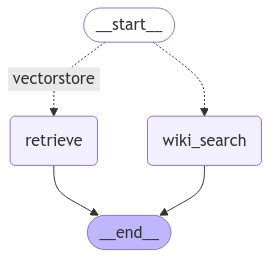

In [26]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [33]:
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():

        pprint(f"Node '{key}':")

    pprint("\n---\n")


pprint(value['documents'][0].dict()['metadata']['description'])
    # pprint(value)

---ROUTE QUESTION---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview In a LLM-powered autonomous agent system, LLM '
 'functions as the agent’s brain, complemented by several key components:')


In [35]:
question = 'explain about the Instruction Prompting'

for output in app.stream({'question':question}):
    for key, value in output.items():

        pprint(f"Node '{key}':")

    pprint("\n---\n")


pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
('Prompt Engineering, also known as In-Context Prompting, refers to methods '
 'for how to communicate with LLM to steer its behavior for desired outcomes '
 'without updating the model weights. It is an empirical science and the '
 'effect of prompt engineering methods can vary a lot among models, thus '
 'requiring heavy experimentation and heuristics.\n'
 'This post only focuses on prompt engineering for autoregressive language '
 'models, so nothing with Cloze tests, image generation or multimodality '
 'models.')
